## Проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

1. Был ли эксперимент успешен в целом.
2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

In [453]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as st
from statsmodels.stats import multicomp 
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')


Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

**users_*.csv** – информация о пользователях:

- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, (лайки/просмотры)∗1000)
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка


**transactions_*.csv** – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

In [454]:
!pip install --upgrade certifi

Requirement already up-to-date: certifi in d:\anaconda3\lib\site-packages (2021.5.30)


In [455]:
users_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_test.csv', sep = ';')
users_control1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_1.csv', sep = ';')
users_control2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_2.csv', sep = ';')
trans_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_test.csv', sep = ';')
trans_control1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_1.csv', sep = ';')
trans_control2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_2.csv', sep = ';')

users_test['group'] = 'test'
users_control1['group'] = 'control1'
users_control2['group'] = 'control2'
trans_test['group'] = 'test'
trans_control1['group'] = 'control1'
trans_control1 = trans_control1[trans_control1['uid'].notna()]

trans_control2['group'] = 'control2'


In [456]:
import urllib.request
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
response = urllib.request.urlopen('https://www.python.org')
print(response.read().decode('utf-8'))

<!doctype html>
<!--[if lt IE 7]>   <html class="no-js ie6 lt-ie7 lt-ie8 lt-ie9">   <![endif]-->
<!--[if IE 7]>      <html class="no-js ie7 lt-ie8 lt-ie9">          <![endif]-->
<!--[if IE 8]>      <html class="no-js ie8 lt-ie9">                 <![endif]-->
<!--[if gt IE 8]><!--><html class="no-js" lang="en" dir="ltr">  <!--<![endif]-->

<head>
    <meta charset="utf-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">

    <link rel="prefetch" href="//ajax.googleapis.com/ajax/libs/jquery/1.8.2/jquery.min.js">
    <link rel="prefetch" href="//ajax.googleapis.com/ajax/libs/jqueryui/1.12.1/jquery-ui.min.js">

    <meta name="application-name" content="Python.org">
    <meta name="msapplication-tooltip" content="The official home of the Python Programming Language">
    <meta name="apple-mobile-web-app-title" content="Python.org">
    <meta name="apple-mobile-web-app-capable" content="yes">
    <meta name="apple-mobile-web-app-status-bar-style" content="black">

    <meta name="

In [457]:
users = pd.concat([users_test, users_control1, users_control2])
trans = pd.concat([trans_test, trans_control1, trans_control2])


In [458]:
users['uid'].nunique()

12912

In [459]:
users.head(3)


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test


In [460]:
trans.head(3)


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942.0,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,892054251.0,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,892236423.0,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test


In [461]:
trans_total = trans.groupby('uid', as_index=False)[['revenue']].sum().rename(columns={'revenue':'total_revenue'})


In [462]:
diff_rev = users[['uid', 'total_revenue']].merge(trans_total, on='uid', how='left').fillna(0)


In [463]:
# Разница в суммарном доходе и сумме транзакций юзеров

diff_rev = diff_rev[diff_rev['total_revenue_x'] != diff_rev['total_revenue_y']]
diff_rev


,uid,total_revenue_x,total_revenue_y
2070,892275462,14885,58968.0
4818,960936960,26,806.0
7678,892355163,0,30264.0


In [464]:
users[users['uid'] == 960936960]


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,control1


In [465]:
trans[trans['uid'] == 960936960]


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control1
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control1
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control1


In [466]:
# Т.к. в суммарном доходе не хватает некоторых транзакций - заполним суммой транзацкий

for user in diff_rev.uid.unique():
    users.loc[users[users['uid'] == user].index[0], 'total_revenue'] = \
            diff_rev[diff_rev['uid'] == user]['total_revenue_y'].values[0]
    

In [467]:
print(users.shape[0], users.uid.nunique())


12912 12912


In [468]:
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0.0,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0.0,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0.0,test
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0.0,test
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0.0,test


In [469]:
users.isna().sum()


uid                     0
age                     0
attraction_coeff        0
coins               12742
country                 0
visit_days           4018
gender                  0
age_filter_start        0
age_filter_end          0
views_count             0
was_premium         11657
is_premium          12372
total_revenue           0
group                   0
dtype: int64

In [470]:
users.nunique()


uid                 12912
age                    69
attraction_coeff      847
coins                  50
country                72
visit_days           2132
gender                  2
age_filter_start       67
age_filter_end         81
views_count           564
was_premium             1
is_premium              1
total_revenue         294
group                   3
dtype: int64

In [471]:
users.dtypes


uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue       float64
group                object
dtype: object

In [472]:
users.describe().round(2)


,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,1.291200e+04,12912.00,12912.00,170.00,12912.00,12912.00,12912.00,12912.00,1255.0,540.0,12912.00
mean,8.917569e+08,32.01,315.46,688.96,0.96,26.82,38.57,46.64,1.0,1.0,546.60
std,1.610285e+06,10.22,323.49,7690.94,0.21,9.45,15.51,285.32,0.0,0.0,5612.88
min,8.910509e+08,16.00,0.00,1.00,0.00,13.00,19.00,0.00,1.0,1.0,0.00
25%,8.913565e+08,25.00,0.00,6.00,1.00,19.00,28.00,1.00,1.0,1.0,0.00
50%,8.917255e+08,30.00,250.00,10.00,1.00,25.00,35.00,6.00,1.0,1.0,0.00
75%,8.920860e+08,38.00,529.00,28.00,1.00,32.00,45.00,21.00,1.0,1.0,0.00
max,1.053059e+09,99.00,1000.00,99958.00,1.00,96.00,102.00,16157.00,1.0,1.0,486330.00


In [473]:
# Ключевые метрики для групп

users_c1 = users[users['group'] == 'control1'].uid.nunique()
users_c2 = users[users['group'] == 'control2'].uid.nunique()
users_t = users[users['group'] == 'test'].uid.nunique()

pay_users_c1 = users[(users['group'] == 'control1') & (users['total_revenue'] > 0)].uid.nunique()
pay_users_c2 = users[(users['group'] == 'control2') & (users['total_revenue'] > 0)].uid.nunique()
pay_users_t = users[(users['group'] == 'test') & (users['total_revenue'] > 0)].uid.nunique()

conv_c1 = np.round(pay_users_c1 / users_c1, 4)
conv_c2 = np.round(pay_users_c2 / users_c2, 4) 
conv_t = np.round(pay_users_t / users_t, 4) 

arpu_c1 = users[users['group'] == 'control1']['total_revenue'].sum() / users_c1
arpu_c2 = users[users['group'] == 'control2']['total_revenue'].sum() / users_c2
arpu_t = users[users['group'] == 'test']['total_revenue'].sum() / users_t

arppu_c1 = users[users['group'] == 'control1']['total_revenue'].sum() / pay_users_c1
arppu_c2 = users[users['group'] == 'control2']['total_revenue'].sum() / pay_users_c2
arppu_t = users[users['group'] == 'test']['total_revenue'].sum() / pay_users_t

total_rv_c1 = users[users['group'] == 'control1']['total_revenue'].sum()
total_rv_c2 = users[users['group'] == 'control2']['total_revenue'].sum()
total_rv_t = users[users['group'] == 'test']['total_revenue'].sum()

print('Control1 - {} пользователей, из них {} платящих c конверсией {}, выручка {}, ARPU: {:.3f}, ARPPU: {:.3f}'
      .format(users_c1, pay_users_c1, conv_c1, total_rv_c1, arpu_c1, arppu_c1))
print('Control2 - {} пользователей, из них {} платящих c конверсией {}, выручка {}, ARPU: {:.3f}, ARPPU: {:.3f}'
      .format(users_c2, pay_users_c2, conv_c2, total_rv_c2, arpu_c2, arppu_c2))
print('Test - {} пользователей, из них {} платящих c конверсией {}, выручка {}, ARPU: {:.3f}, ARPPU: {:.3f}'
      .format(users_t, pay_users_t, conv_t, total_rv_t, arpu_t, arppu_t))


Control1 - 4340 пользователей, из них 194 платящих c конверсией 0.0447, выручка 2671279.0, ARPU: 615.502, ARPPU: 13769.479
Control2 - 4264 пользователей, из них 190 платящих c конверсией 0.0446, выручка 2010476.0, ARPU: 471.500, ARPPU: 10581.453
Test - 4308 пользователей, из них 148 платящих c конверсией 0.0344, выручка 2375971.0, ARPU: 551.525, ARPPU: 16053.858


##### Сумма доходов по типу продукта

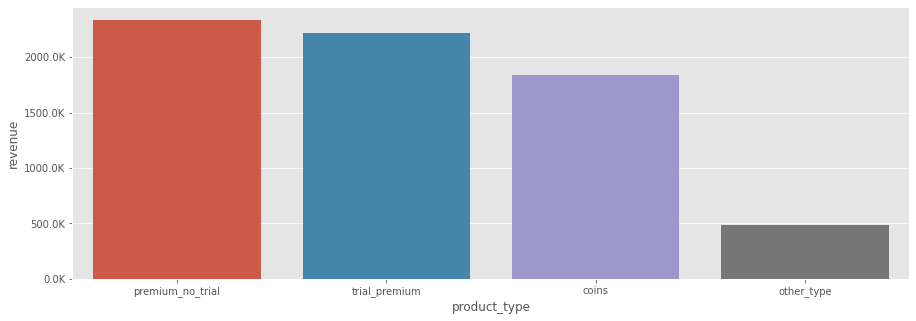

In [474]:
plt.figure(figsize=(15,5))
g = sns.barplot(data=trans.groupby('product_type', as_index=False).revenue.sum().sort_values(by='revenue',
                                                                        ascending=False), x='product_type', y='revenue')
ylabels = ['{}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)
plt.show()


In [475]:
users['paying_user'] = [1 if i > 0 else 0 for i in users['total_revenue']]


##### Конверсия в платящего пользователя по группам


In [476]:
users['paying_user'] = [1 if i > 0 else 0 for i in users['total_revenue']]

fig = px.histogram(users[['group', 'paying_user']].dropna(), x='group', 
                   color='paying_user')
fig.show()


##### Распределения суммарного дохода по группам

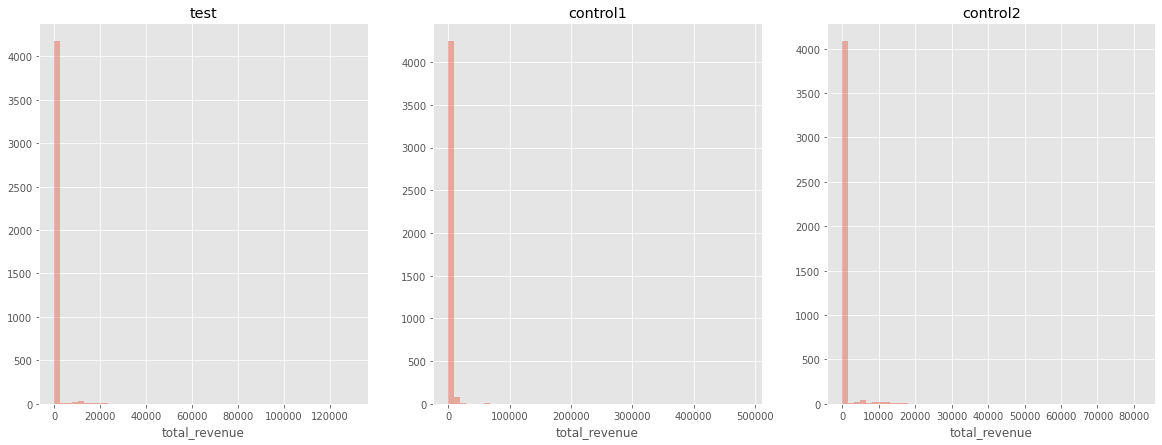

In [477]:
plt.figure(figsize=(20, 7))  # Гистограмма распределений контрольной и тестовой группы

for i,group in enumerate(users.group.unique()):
    plt.subplot(1, 3, i+1)
    plt.title(group)
    sns.distplot(users[users['group'] == group].total_revenue, kde=False)



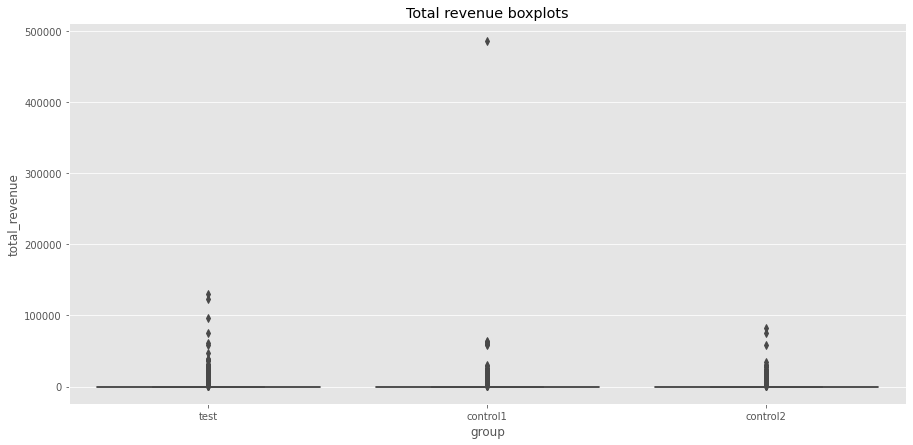

In [478]:
plt.figure(figsize=(15, 7))  # Боксплоты распределений контрольной и тестовой группы

sns.boxplot(x="group", y="total_revenue", data=users)
plt.title('Total revenue boxplots')
plt.show()


Явный выброс в первой контрольной группе - скорее всего следует исключить при использовании АА-теста

Корректность работы сплитовалки можно проверить только если есть много одинаковых пользователей; если есть ровно один, который сам по себе как половина других пользователей, то его невозможно "правильно" распределить по сплитам

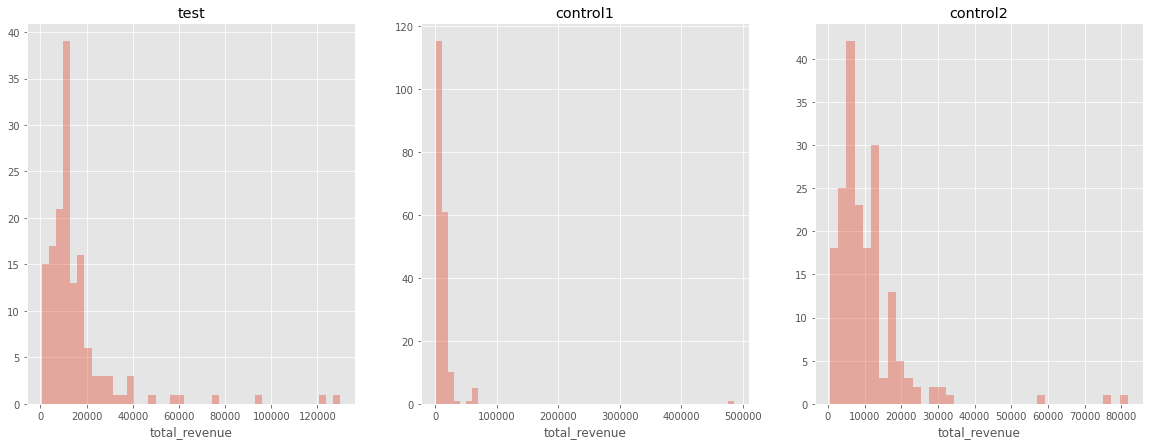

In [479]:
# Гистограмма распределений контрольной и тестовой группы

plt.figure(figsize=(20, 7))

for i,group in enumerate(users.group.unique()):
    plt.subplot(1, 3, i+1)
    plt.title(group)
    sns.distplot(users[(users['group'] == group) & (users['total_revenue'] > 0)].total_revenue, kde=False)
    

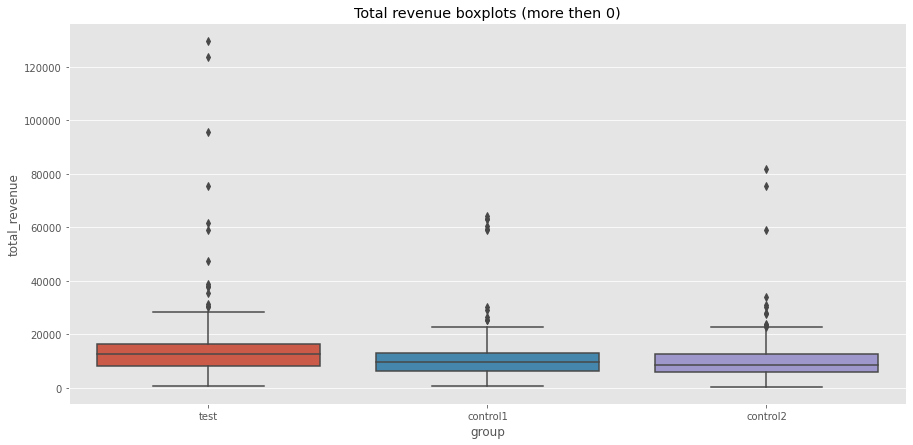

In [480]:
plt.figure(figsize=(15, 7))

sns.boxplot(x="group", y="total_revenue", data=users[(users['total_revenue'] > 0) & (users['total_revenue'] < 400000)])
# Удаление явного выброса для детализации графика
plt.title('Total revenue boxplots (more then 0)')
plt.show()


### AA-тест для проверки корректности системы сплитования (по величине транзакций)

In [481]:
def aafunc(df1, df2):
    simulations = 10000
    n_s = 100
    res = []
    alpha = 0.05

    for i in range(simulations):
        s1 = df1.revenue.sample(n_s, replace=False).values
        s2 = df2.revenue.sample(n_s, replace=False).values
        res.append(st.ttest_ind(s1, s2, equal_var=False)[1])
        
    plt.hist(res, bins = 50, edgecolor='black', linewidth=1.2)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title('Histogram of ttest A/A simulations')
    plt.show()

    return print('FPR is {}'.format(sum(np.array(res) < alpha) / simulations))

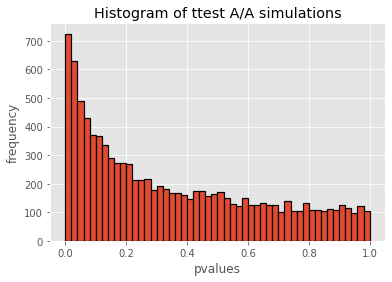

FPR is 0.1612


In [482]:
aafunc(trans[trans['group'] == 'control1'], trans[trans['group'] == 'control2'])

In [483]:
users[users['group'] == 'control1'].sort_values(by='total_revenue', ascending=False).head(5)[['uid', 'total_revenue']]


,uid,total_revenue
1427,892333905,486330.0
2296,892216461,64298.0
874,891383310,63037.0
1815,892366260,63024.0
284,892421277,60333.0


In [484]:
users[users['group'] == 'control2'].sort_values(by='total_revenue', ascending=False).head(5)[['uid', 'total_revenue']]


,uid,total_revenue
1360,891778551,81796.0
1216,892307238,75647.0
2070,892121727,58968.0
1656,891637005,34125.0
1265,892128138,30849.0


Наличие пользователя, чей суммарный доход явно больше всех остальных юзеров, возможно не дает корректно сплитовать клиентов по группам, попробуем исключить его и прогнать тест еще раз

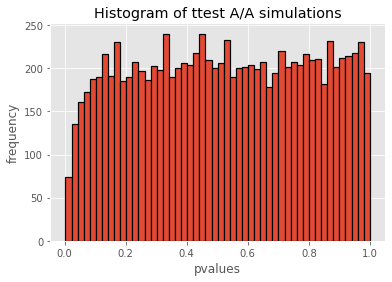

FPR is 0.0281


In [485]:
aafunc(trans[(trans['group'] == 'control1') & (trans['uid'] != 892333905)], 
       trans[trans['group'] == 'control2'])


Pvalue < 0.05 в 2% случаев и распределение похоже на равномерное - система сплитования работает корректно

In [486]:
# Исключим клиента с аномальным доходом для проведения последующего анализа

users = users[users['uid'] != 892333905]
trans = trans[trans['uid'] != 892333905]


Варианты использования контрольных группы для сравнения:

1) Объединить 2 контрольные в одну общую контрольную и сравнивать с тестовой группой  
2) Выбрать 1 из контрольных для сравнения - используем контрольную группу 1  

In [487]:
# Будем сохранять гипотезы и p_value каждой гипотезы с целью последующей поправки на множественную проверку гипотез

result_df = pd.DataFrame(columns=['Hypotheses', 'P_values', 'Diff_C1&T'])


### Сравнение конверсий в платящего пользователя контрольной и тестовой группы

In [488]:
print(conv_c1, conv_t) # Конверсия в контрольной группе лучше


0.0447 0.0344


In [489]:
# Критерий Хи-квадрат

stat, p, dof, expected = st.chi2_contingency(pd.crosstab(users[users['group'] != 'control2'].paying_user, 
                                                               users[users['group'] != 'control2'].group))
np.round(p, 5)


0.0181

In [490]:
trans[(trans['group'] == 'control1')]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,control1
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,control1
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,control1
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type,control1
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins,control1
...,...,...,...,...,...,...,...,...,...
372,891556971.0,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886.0,68.0,none,premium_no_trial,control1
373,892052106.0,Spain,2017-10-22 01:38:00,2017-10-29 03:44:00,12883.0,147.0,trial_vip_popup,trial_premium,control1
374,892145004.0,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919.0,147.0,trial_vip_popup,trial_premium,control1
375,891458229.0,Spain,2017-03-11 12:12:00,2017-04-11 03:43:00,6305.0,19.0,menu,coins,control1


Согласно критерию Хи-квадрат - могли бы отклонить гипотезу о равенстве конверсий обеих групп на уровне значимости 0.05, однако выводы отклонять ту или иную гипотезу будем делать после поправки на множественное сравнение

##### Использование бутстрапа для сравнения конверсий


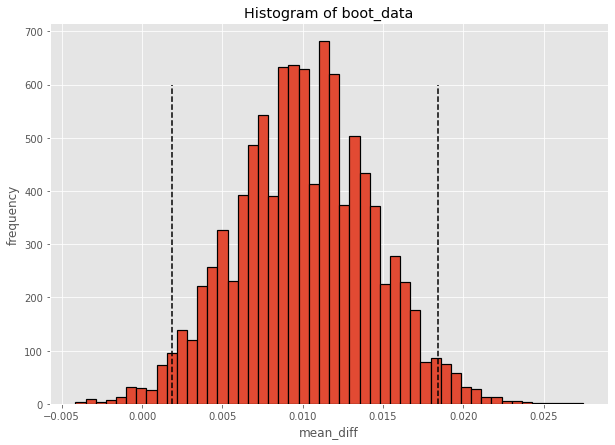

2.5%-ый перцентиль:0.00, 97.5%-ый перцентиль:0.02, p-value: 0.016


In [491]:
x = users.query('group == "control1"')['paying_user']
y = users.query('group == "test"')['paying_user']

boot_len = max([len(x), len(y)])
boot_data = []

for i in range(10000): 
    samples_1 = x.sample(boot_len, replace = True).values
    samples_2 = y.sample(boot_len, replace = True).values
    conv_1 = samples_1.sum() / samples_1.shape[0]
    conv_2 = samples_2.sum() / samples_2.shape[0]
    boot_data.append(conv_1 - conv_2)

pd_boot_data = pd.DataFrame(boot_data)

left_quant = (1 - 0.95)/2
right_quant = 1 - (1 - 0.95) / 2
ci = pd_boot_data.quantile([left_quant, right_quant])

p_1 = st.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
p_2 = st.norm.cdf(x = 0, loc=-np.mean(boot_data), scale=np.std(boot_data))
p_value = min(p_1, p_2) * 2

plt.figure(figsize=(10, 7))
plt.hist(pd_boot_data[0], bins = 50, edgecolor='black', linewidth=1.2)
plt.vlines(ci, 0, 600, linestyle='--', colors=['black'])
plt.xlabel('mean_diff')
plt.ylabel('frequency')
plt.title('Histogram of boot_data')
plt.show()

print('2.5%-ый перцентиль:{:.2f}, 97.5%-ый перцентиль:{:.2f}, p-value: {:.3f}'
      .format(ci.values[0][0].astype('float64'), ci.values[1][0].astype('float64'), p_value))

result_df.loc[result_df.shape[0]] = ['Различия в конверсиях в платящего пользователя', p_value, 
                                     np.round(conv_c1 - conv_t, 4)]


### Сравнение средних платежей в контрольной и тестовой группе

In [492]:
mean_tr_c1 = np.mean(trans[trans['group'] == 'control1'].revenue)
mean_tr_t = np.mean(trans[trans['group'] == 'test'].revenue)


In [493]:
# Тест Шапиро-Уилка для проверки нормальности распределений

print(st.shapiro(trans[trans['group'] == 'control1'].revenue)[1], 
      st.shapiro(trans[trans['group'] == 'test'].revenue)[1])


5.1500055232869805e-28 3.996793050437411e-27


In [494]:
trans[trans['group'] == 'control1']

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,control1
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,control1
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,control1
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type,control1
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins,control1
...,...,...,...,...,...,...,...,...,...
372,891556971.0,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886.0,68.0,none,premium_no_trial,control1
373,892052106.0,Spain,2017-10-22 01:38:00,2017-10-29 03:44:00,12883.0,147.0,trial_vip_popup,trial_premium,control1
374,892145004.0,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919.0,147.0,trial_vip_popup,trial_premium,control1
375,891458229.0,Spain,2017-03-11 12:12:00,2017-04-11 03:43:00,6305.0,19.0,menu,coins,control1


Гипотеза о нормальности распределений отклоняется, не совсем корректно использовать T-test - применим бутстрап

##### Использование бутстрапа для сравнения среднего платежа

In [495]:
def bootstrap(x, y, n=10000, bootstrap_conf_level=0.95):
    
    boot_len = max([len(x), len(y)])
    boot_data = []
    
    for i in (range(n)): 
        samples_1 = x.sample(boot_len, replace = True).values
        samples_2 = y.sample(boot_len, replace = True).values
        boot_data.append(np.mean(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = st.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    plt.figure(figsize=(10, 7))
    plt.hist(pd_boot_data[0], bins = 50, edgecolor='black', linewidth=1.2)
    plt.vlines(ci, 0, 600, linestyle='--', colors=['black'])
    plt.xlabel('mean_diff')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
       
    print('2.5%-ый перцентиль:{:.2f}, 97.5%-ый перцентиль:{:.2f}, p-value: {:.3f}'
          .format(ci.values[0][0].astype('float64'), ci.values[1][0].astype('float64'), p_value))
    return p_value


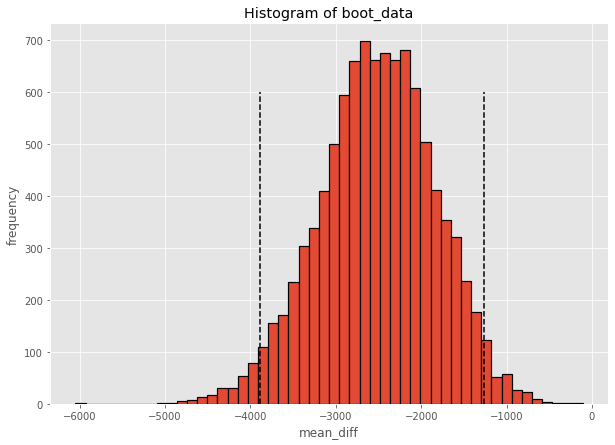

2.5%-ый перцентиль:-3893.46, 97.5%-ый перцентиль:-1263.20, p-value: 0.000


In [496]:
p_value = bootstrap(trans[trans['group'] == 'control1'].revenue, 
       trans[trans['group'] == 'test'].revenue)

result_df.loc[result_df.shape[0]] = ['Различия в средних платежах', p_value, np.round(mean_tr_c1 - mean_tr_t, 4)]


### Сравнение ARPU в контрольной и тестовой группе

In [497]:
print(st.shapiro(users[users['group'] == 'control1'].total_revenue.sample(1000))[1], 
      st.shapiro(users[users['group'] == 'test'].total_revenue.sample(1000))[1])


0.0 0.0


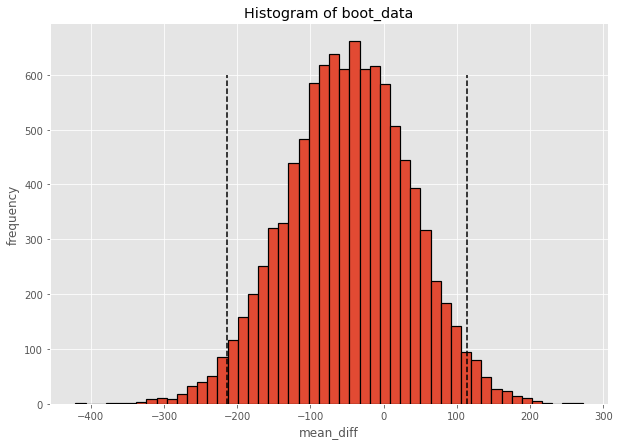

2.5%-ый перцентиль:-213.77, 97.5%-ый перцентиль:113.90, p-value: 0.564


In [498]:
p_value = bootstrap(users[users['group'] == 'control1'].total_revenue, 
       users[users['group'] == 'test'].total_revenue)
result_df.loc[result_df.shape[0]] = ['Различия в ARPU', p_value, np.round(arpu_c1 - arpu_t, 4)]


### Сравнение ARPPU в контрольной и тестовой группе

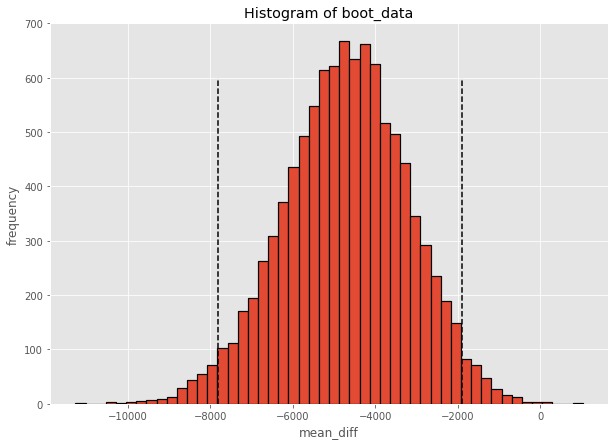

2.5%-ый перцентиль:-7802.49, 97.5%-ый перцентиль:-1887.25, p-value: 0.002


In [499]:
p_value = bootstrap(users[(users['group'] == 'control1') & (users['total_revenue'] > 0)].total_revenue, 
       users[(users['group'] == 'test') & (users['total_revenue'] > 0)].total_revenue)
result_df.loc[result_df.shape[0]] = ['Различия в ARPPU', p_value,  np.round(arppu_c1 - arppu_t, 4)]


### Сравнение ARPU в контрольной и тестовой группе по разным типам продукта

In [500]:
comp_df = users.merge(trans[['uid', 'product_type']].drop_duplicates(), on='uid').query('group != "control2"')
comp_df['combination'] = comp_df['group'] + '/' + comp_df['product_type']

comp_df = comp_df[~comp_df['product_type'].isin(['coins', 'other_type'])]

groups = []
for i, comb in enumerate(comp_df.combination.unique()):
    temp = comp_df.query('combination == @comb').total_revenue.values
    groups.append(temp)
    

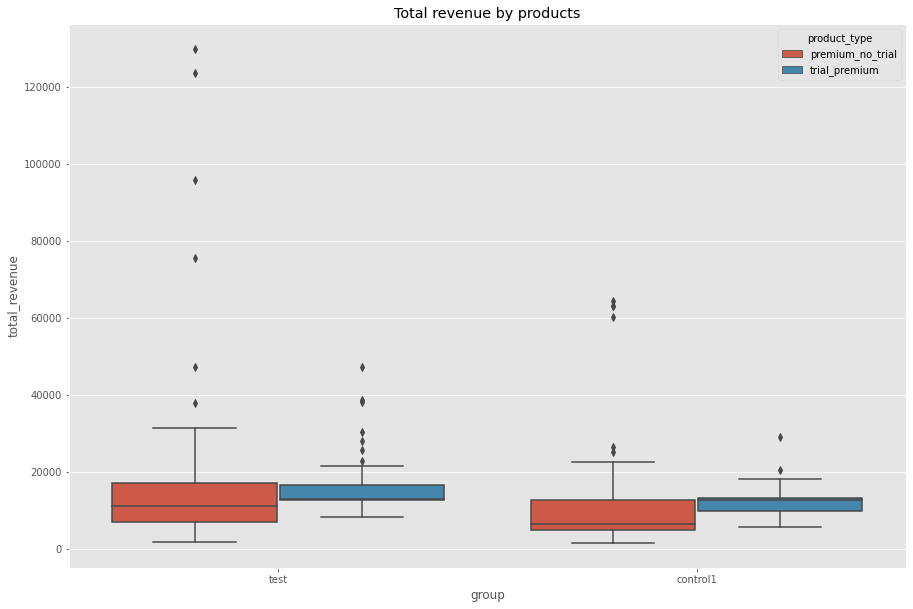

In [501]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='group', y='total_revenue', hue='product_type', data=comp_df)
plt.title('Total revenue by products')
plt.show()


Дисперсионный анализ и критерий Тьюки имеют условия применимости: нормальность распределений данных и однородность групповых дисперсий

In [502]:
for i in range(len(groups)):
    print(st.shapiro(groups[i])[1])


2.047491814765809e-13
2.980714286504593e-10
4.229189342345096e-15
6.623766068969417e-08


In [503]:
st.levene(groups[0], groups[1],groups[2],groups[3])


LeveneResult(statistic=5.558340572299528, pvalue=0.0010126779731757399)

Условия применимости не выполняются - прибегнем к непараметрическому аналогу и бутстрапу

In [504]:
st.kruskal(groups[0], groups[1],groups[2],groups[3])


KruskalResult(statistic=50.81926350112727, pvalue=5.3456214785530577e-11)

Гипотеза о равенстве медиан дохода отклоняется - в целях интерпретации медианы рассматриваться не будут, можно перемешать хвосты распределений так, что медианы останутся на месте, а выручка резко вырастет или упадёт

In [505]:
arpu_tr_pr_c1 = np.mean(comp_df.query('product_type == "trial_premium"')[comp_df['group'] == 'control1'].total_revenue)
arpu_tr_pr_t = np.mean(comp_df.query('product_type == "trial_premium"')[comp_df['group'] == 'test'].total_revenue)

arpu_tr_npr_c1 = np.mean(comp_df.query('product_type == "premium_no_trial"')[comp_df['group'] == 'control1'].total_revenue)
arpu_tr_npr_t = np.mean(comp_df.query('product_type == "premium_no_trial"')[comp_df['group'] == 'test'].total_revenue)


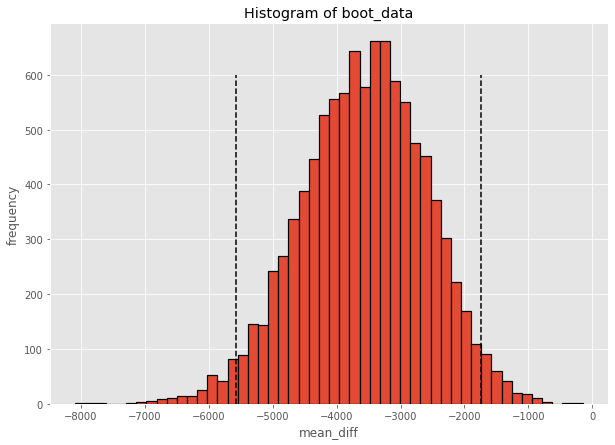

2.5%-ый перцентиль:-5568.66, 97.5%-ый перцентиль:-1743.16, p-value: 0.000


In [506]:
p_value = bootstrap(comp_df.query('product_type == "trial_premium"')[comp_df['group'] == 'control1'].total_revenue, 
       comp_df.query('product_type == "trial_premium"')[comp_df['group'] == 'test'].total_revenue)

result_df.loc[result_df.shape[0]] = ['Различия в ARPU trial_premium', p_value, np.round(arpu_tr_pr_c1 - arpu_tr_pr_t, 4)]


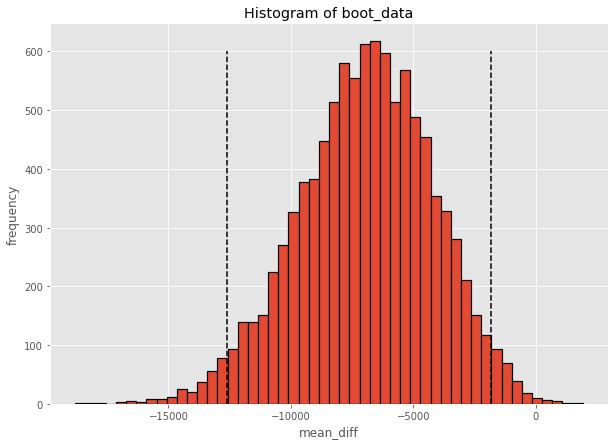

2.5%-ый перцентиль:-12618.20, 97.5%-ый перцентиль:-1829.78, p-value: 0.012


In [507]:
p_value = bootstrap(comp_df.query('product_type == "premium_no_trial"')[comp_df['group'] == 'control1'].total_revenue, 
       comp_df.query('product_type == "premium_no_trial"')[comp_df['group'] == 'test'].total_revenue)

result_df.loc[result_df.shape[0]] = ['Различия в ARPU premium_no_trial', p_value, np.round(arpu_tr_npr_c1 - arpu_tr_npr_t, 4)]


##### Поправка Холма-Бонферрони

In [508]:
result_df = result_df.sort_values(by='P_values')
result_df = result_df.reset_index().drop('index', axis=1)

result_df


,Hypotheses,P_values,Diff_C1&T
0,Различия в средних платежах,0.000209,-2515.1495
1,Различия в ARPU trial_premium,0.000257,-3578.6897
2,Различия в ARPPU,0.001764,-2284.3787
3,Различия в ARPU premium_no_trial,0.011697,-6907.4904
4,Различия в конверсиях в платящего пользователя,0.016134,0.0103
5,Различия в ARPU,0.564239,63.9768


In [509]:
for i, p_value in enumerate(result_df.P_values):
    if p_value * (result_df.shape[0]-(i+1)+1) < 0.05:
        print('Гипотеза H0 {} отвергается'.format(result_df.iloc[i, 0]))
    else:
        print('Гипотезы H0 {} не отвергаются'.format(result_df.iloc[i:, 0].values))
        break


Гипотеза H0 Различия в средних платежах отвергается
Гипотеза H0 Различия в ARPU trial_premium отвергается
Гипотеза H0 Различия в ARPPU отвергается
Гипотеза H0 Различия в ARPU premium_no_trial отвергается
Гипотеза H0 Различия в конверсиях в платящего пользователя отвергается
Гипотезы H0 ['Различия в ARPU'] не отвергаются


#### Общие выводы исследования (формулируются по проверенным гипотезам):

- **Средний платеж** в тестовой группе значимо **лучше**
- **Конверсия в платящего пользователя** значимо **лучше** в контрольной группе
- **ARPPU** значимо **лучше** в тестовой группе
- **ARPU** обеих групп не различаются
- **ARPU** по пользователям с продуктом trial_premium значимо **лучше** в тестовой группе 
- **ARPU** по пользователям с продуктом premium_no_trial значимо **лучше** в тестовой группе 

По совокупности проверенных гипотез - эксперимент успешен, выбор делается в пользу изменений, примененных в тестовой групппе